In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

(400, 400)

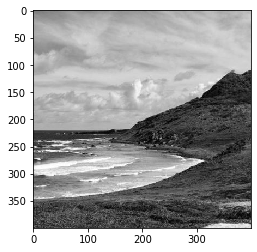

In [4]:
imag = cv2.imread('paisagem.jpg', 0)
# plt.figure(figsize=(10,10))
plt.imshow(imag, 'gray')
imag.shape

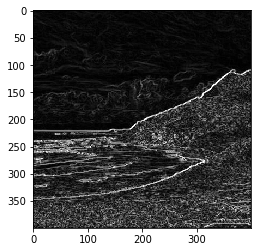

In [5]:
def getGradientMagnitude(im):
    "Get magnitude of gradient for given image"
    ddepth = cv2.CV_32F
    dx = cv2.Sobel(im, ddepth, 1, 0)
    dy = cv2.Sobel(im, ddepth, 0, 1)
    dxabs = cv2.convertScaleAbs(dx)
    dyabs = cv2.convertScaleAbs(dy)
    mag = cv2.addWeighted(dxabs, 0.5, dyabs, 0.5, 0)
    return mag

# plt.figure(figsize=(10,10))
plt.imshow(getGradientMagnitude(imag), 'gray')

In [6]:
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

In [14]:
def my_seam(image, iterations=1, axis=1):
    
    ret = image.copy()
    
    if iterations < 1:
        iterations = 1
        
    if axis == 0:
        ret = rotate_bound(ret, 90)
    
    for k in range(iterations):
        height = ret.shape[0]
        width = ret.shape[1]
        mag = getGradientMagnitude(ret)

        mask = np.zeros(ret.shape).astype('uint16')

        mask[0, :] = mag[0, :]

        for i in range(1, height, 1):
            for j in range(0, width, 1):
                if(j == 0):
                    mask[i,j] = mag[i,j] + np.min((mask[i-1, j], mask[i-1, j+1]))
                elif(j == width-1):
                    mask[i,j] = mag[i,j] + np.min((mask[i-1, j-1], mask[i-1, j]))
                else:
                    mask[i,j] = mag[i,j] + np.min((mask[i-1, j-1], mask[i-1, j], mask[i-1, j+1]))

        index = np.argmin(mask[height-1, :])

        for i in range(height-1, -1, -1):
            ret[i, index:width-2] = ret[i, index+1:width-1]
            if index == 0:
                index = np.argmin((mask[i-1, index], mask[i-1, index+1]))
            elif index == width-1:
                index = (index-1) + np.argmin((mask[i-1, index-1], mask[i-1, index]))
            else:
                index = (index-1) + np.argmin((mask[i-1, index-1], mask[i-1, index], mask[i-1, index+1]))

        ret = ret[:, :-1]
        
    if axis == 0:
        ret = rotate_bound(ret, -90)
        
    return ret

CPU times: user 3min 15s, sys: 1.37 s, total: 3min 16s
Wall time: 3min 14s


(400, 300)

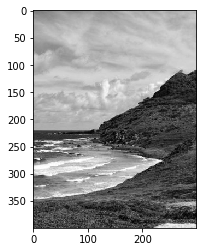

In [19]:
%%time
a = my_seam(imag, iterations=100, axis=1)
plt.imshow(a, 'gray')
a.shape

In [16]:
a.shape

(400, 395)

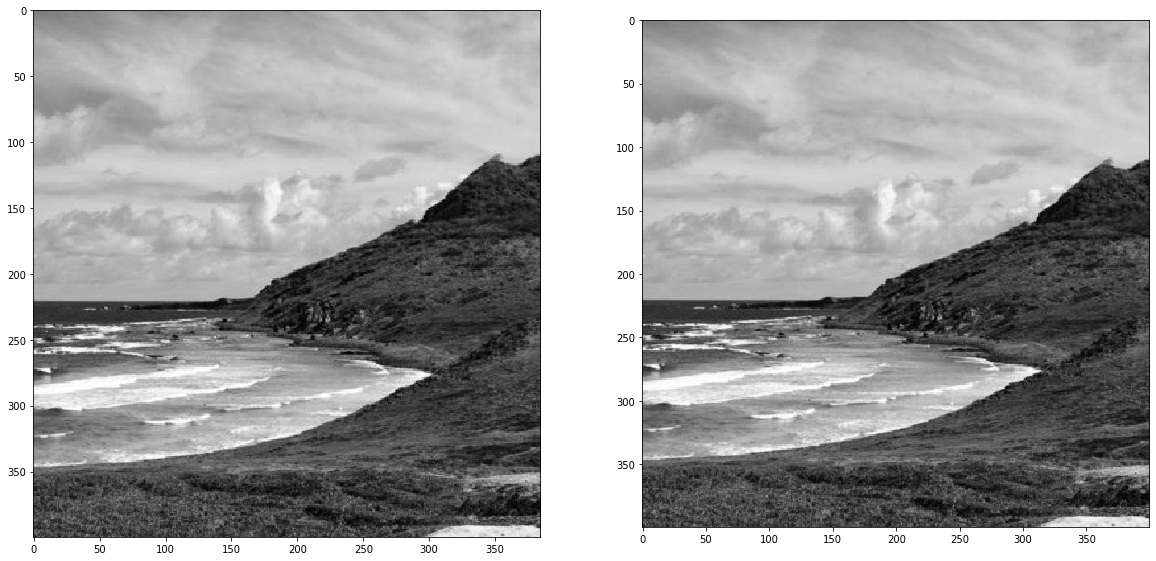

In [13]:
plt.figure(figsize=(20,20))
plt.subplot(121), plt.imshow(a, 'gray');
plt.subplot(122), plt.imshow(imag, 'gray');